# Imports

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
import IPython.display as pyDisplay
import matplotlib.transforms as transforms 
import scipy.special as sciSpec
import subprocess
import tfs

from cpymad.madx import Madx
import Backend.Constants as cst
import Backend.WCTools as WCTools
import Backend.MADXTools as MADXTools

#import xline as xl
#import xobjects as xo
#import xtrack as xt
#import xpart as xp

import makeSkeleton

# Utilities

In [2]:
def plotKick(x,y,DPx,DPy,title='',ax=None,**kwargs):
    if ax is None:
        ax = plt.gca()
    plt.title(title,fontsize=25)
    arrowLength = 0.5*np.max(np.diff(np.sort(x/1e-3)))

    for _x,_y,_DPx,_DPy in zip(x,y,DPx,DPy):
        thisNorm = WCTools.vecNorm([ _DPx,_DPy])
        plt.arrow(_x/1e-3, _y/1e-3, _DPx/thisNorm*arrowLength, _DPy/thisNorm*arrowLength,head_width=0.1, head_length=0.1)

    plt.scatter(x/1e-3,y/1e-3,c=WCTools.vecNorm([DPx,DPy]),zorder=len(x)+1,**kwargs)
    cbar = plt.colorbar()
    cbar.set_label('Kick',fontsize=20)
    plt.xlabel('x [mm]',fontsize=20)
    plt.ylabel('y [mm]',fontsize=20)
    plt.axis('square')
    
    
def importTRK(filename):
    with open(filename, "r+") as f:
        content = f.readlines()
        f.seek(0)
        for line in content:
            if '#segment' not in line:
                f.write(line)
        f.truncate()

    tracked = tfs.read(filename)
    tracked.columns = tracked.columns.str.lower()
    
    return tracked

def importTwiss(filename):
    twiss = tfs.read(filename)
    twiss.columns = list(twiss.columns.str.lower())
    twiss.name = twiss.name.str.lower()
    twiss.keyword = twiss.keyword.str.lower()
    
    return twiss

def PLOTFODO(twiss,title=''):
    # Plotting beta function
    #---------------------------    
    
    plt.title(title,loc='left')
    axLeft = plt.gca()
    h1, = plt.plot(twiss['s'],twiss['betx'],'b-',label=r'$\beta_x$')
    h2, = plt.plot(twiss['s'],twiss['bety'],'r-',label=r'$\beta_y$')
    plt.ylabel(r'$\beta$ [m]')

    axRight = plt.twinx()
    h3, = plt.plot(twiss['s'],twiss['dx'],'g-',label=r'$D_x$')
    h4, = plt.plot(twiss['s'],twiss['dy'],'y-',label=r'$D_y$')
    plt.legend(handles=[h1,h2,h3,h4],ncol=4,loc='upper center', bbox_to_anchor=(0.5, 1.12))
    plt.ylabel(r'$D$ [m]')

    plt.xlabel('s [m]')


    # Adding Quad strength
    #--------------------------- 
    axOff = axLeft.twinx()
    plt.plot(twiss['s'],0*twiss['s'],'k')
    MADXTools.plotElements(twiss,ax=axOff)
    axOff.axis('off')
    #plt.ylim([-0.01,0.01])

 ## `__repr__`

In [3]:
def custom_repr(self):
    repr = ''
    repr +='cpymad.madx.Madx Object\n'
    repr +=40*'='+'\nself.sequence\n' + 40*'='+'\n'
    repr +=str(pd.Series(self.sequence))
    
    repr +='\n'+40*'='+'\nself.globals\n' + 40*'='+'\n'
    repr +=str(pd.Series(self.globals))
    print(repr)
    #return repr

# LHC sequence

The original sequence file was taken from:

`/afs/cern.ch/eng/lhc/optics/lhc_current/lhc_as-built.seq`

And the magnet strength is contained in:

`/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx`

# Saving Skeleton

In [2]:
makeSkeleton.main(toKeep = ['marker','sbend','rbend','quadrupole','rfcavity'],
                  fileName = 'lhcb1_linear.seq',
                  original_seq = 'lhc_as-built.seq',
                  sequence = 'lhcb1')

In [3]:
makeSkeleton.main(toKeep = ['sextupole','marker','sbend','rbend','quadrupole','rfcavity'],
                  fileName = 'lhcb1_sextupole.seq',
                  original_seq = 'lhc_as-built.seq',
                  sequence = 'lhcb1')

# LHC Skeleton

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
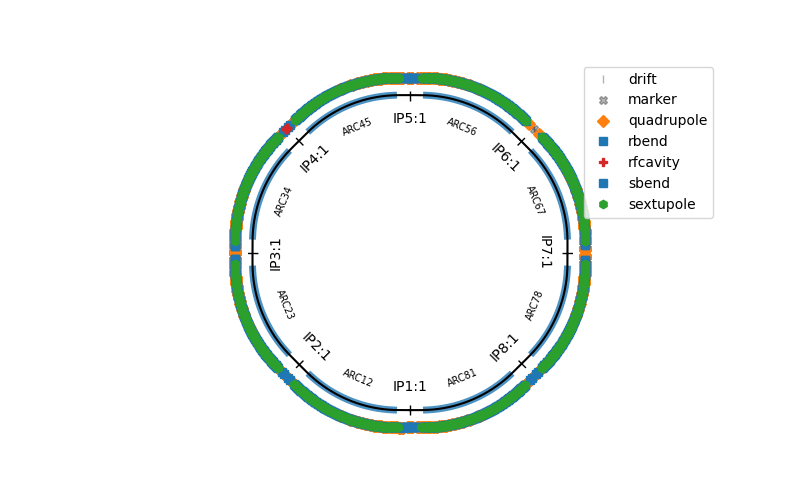

In [4]:
sequenceNames = ['lhcb1_linear','lhcb1_sextupole']

# Importing LHC sequence :
#===========================================
mad = Madx()
mad.option(echo = True, warn = True)
for seq in sequenceNames:
    mad.call(file=f'{seq}.seq')
    
# Applying optics
mad.call(file='/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx')
# Adding beam 
mad.command.beam(particle='proton',charge=1,npart=1,energy=7000)
#===========================================



# Plot Survey
%matplotlib widget
for seq in sequenceNames:
    # Generating survey
    mad.sequence[seq].use()
    mad.survey(theta0=np.pi)
    
    plt.figure(figsize=(8,5))
    survey = MADXTools.plotSurvey(mad.table['survey'].dframe())




# Comparing arc twiss

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
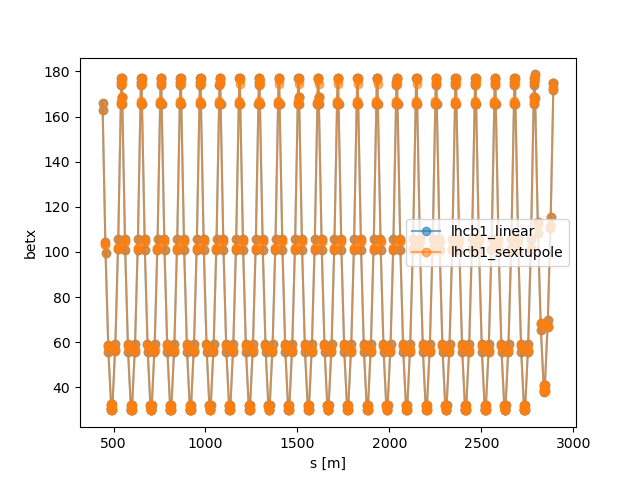

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
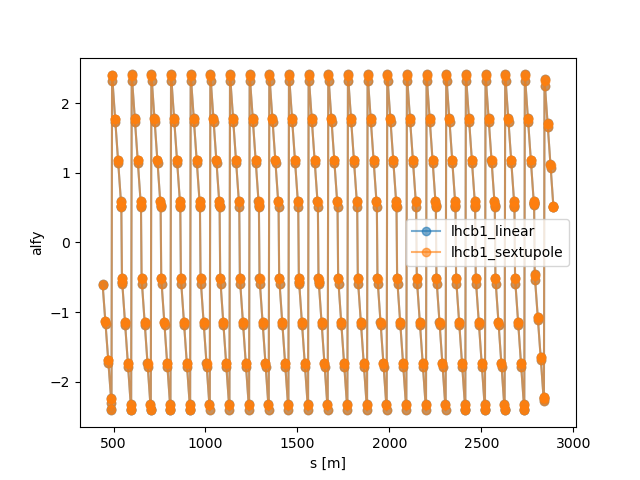

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
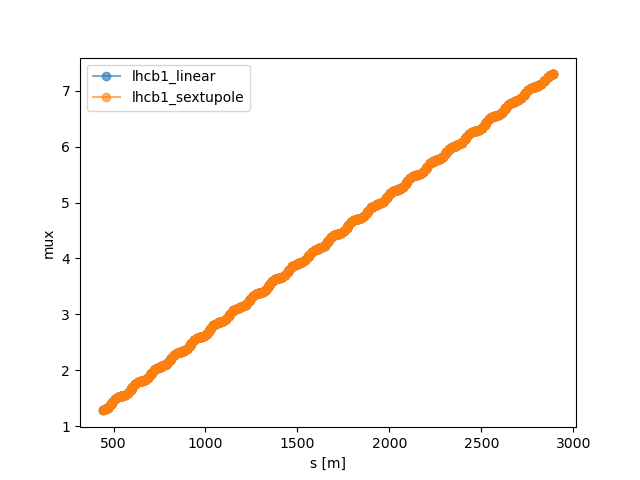

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [3]:
plt.close('all')
for seq in sequenceNames:
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()
    twiss_elements = twiss[twiss['keyword']!='drift'].copy()
    
    for param in ['betx','bety','alfx','alfy','mux','muy']:
        thisArc = twiss.loc[f's.arc.12.b1':f'e.arc.12.b1']
        
        plt.figure(param)
        plt.plot(thisArc['s'],thisArc[param],'-o',alpha=0.6,label=seq)
        plt.xlabel('s [m]')
        plt.ylabel(param)
        plt.legend()
        
        
        

# Any difference?

In [4]:
mad.sequence['lhcb1_linear'].use()
mad.twiss()
twiss = mad.table['twiss'].dframe()
twiss_linear = twiss[~twiss['keyword'].str.contains('drift|sextupole')].copy()

mad.sequence['lhcb1_sextupole'].use()
mad.twiss()
twiss = mad.table['twiss'].dframe()
twiss_sextupole = twiss[~twiss['keyword'].str.contains('drift|sextupole')].copy()

for entry in twiss_linear.columns:
    comparison = twiss_linear[entry].equals(twiss_sextupole[entry])
    if ~comparison and type(twiss_linear[entry][0]) is not str:
        
        maxDiff = np.argmax(np.abs(np.array(twiss_linear[entry])-np.array(twiss_sextupole[entry])))
        err = np.array(twiss_linear[entry]-twiss_sextupole[entry])[maxDiff]/np.array(twiss_linear[entry])[maxDiff]
        print(f'{entry} -> {comparison}, \t\t Max Rel. Diff: {err}')


s -> False, 		 Max Rel. Diff: 2.4256254536642306e-14
betx -> False, 		 Max Rel. Diff: 1.452597371789077e-07
alfx -> False, 		 Max Rel. Diff: 1.4544671817081653e-07
mux -> False, 		 Max Rel. Diff: -1.4692183898839117e-09
bety -> False, 		 Max Rel. Diff: -1.274401995278481e-07
alfy -> False, 		 Max Rel. Diff: -1.3497130879192462e-07
muy -> False, 		 Max Rel. Diff: -3.7433761504064046e-09
x -> False, 		 Max Rel. Diff: 9.151485495925986e-08
px -> False, 		 Max Rel. Diff: 9.147173021184433e-08
t -> False, 		 Max Rel. Diff: 1.2820580320672677e-05
dx -> False, 		 Max Rel. Diff: 0.9243614653303726
dpx -> False, 		 Max Rel. Diff: 0.9240671210012743
alfa -> False, 		 Max Rel. Diff: 8.102890215315173e-07
sig11 -> False, 		 Max Rel. Diff: 1.4526861171320695e-07
sig12 -> False, 		 Max Rel. Diff: 1.4545559736258526e-07
sig15 -> False, 		 Max Rel. Diff: 0.946641786298037
sig21 -> False, 		 Max Rel. Diff: 1.454555969231084e-07
sig22 -> False, 		 Max Rel. Diff: 1.4595839438254773e-07
sig25 -> False, 		

# Phase Space plots

In [6]:
# Generate particle distribution

def generateCoord(Jx,alpha,beta,NParticles,plane='x',PT = 0):
    
    gamma = (1+alpha**2)/beta
    
    phi = np.linspace(0,2*np.pi,NParticles+1)[1:]
    x  = np.sqrt(2*beta*Jx)*np.cos(phi)
    px = -np.sqrt(2*Jx/beta)*(np.sin(phi)+alpha*np.cos(phi))
    
    coordinates = pd.DataFrame({f'J{plane}':Jx*np.ones(len(x)),f'{plane}':x,f'p{plane}':px,f'pt':PT*np.ones(len(x))})
    
    return coordinates
    

## MAD-X tracking

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
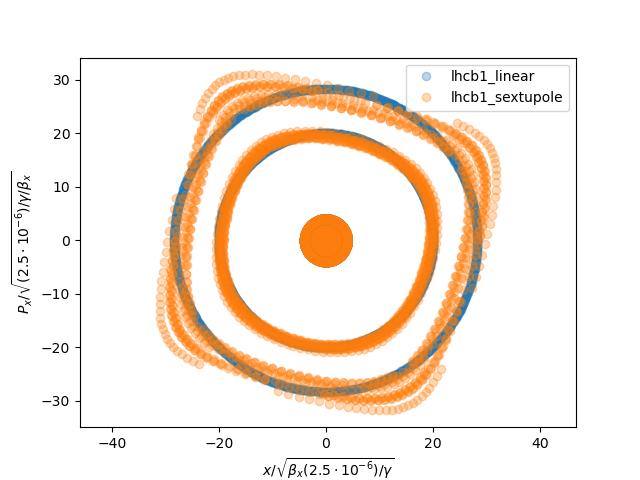

In [5]:
sequenceNames = ['lhcb1_linear','lhcb1_sextupole']

# Importing LHC sequence :
#===========================================
mad = Madx()
mad.option(echo = True, warn = True)
for seq in sequenceNames:
    mad.call(file=f'{seq}.seq')
    
# Applying optics
mad.call(file='/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx')
# Adding beam 
mad.command.beam(particle='proton',charge=1,npart=1,energy=7000)
#===========================================


summary = pd.DataFrame()
for seq in sequenceNames:
    # Sending sequence to xsuite
    mad.input(f'''use, sequence = {seq}; 
                select,flag=makethin,slice=2,range=#s/#e;
                makethin,sequence = {seq};''')
    
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()
    alfMin = np.argmin(np.abs(twiss['alfx'][twiss['keyword']!='drift']))
    alfMinLoc = twiss[twiss['keyword']!='drift'].index[alfMin]
    
    mad.input(f'''  SEQEDIT, SEQUENCE={seq};
                    FLATTEN;
                        CYCLE, START={alfMinLoc};
                    FLATTEN;
                    ENDEDIT;''')
    
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()
    
    NParticles = 10
    
    coordinates = pd.DataFrame()
    for Jx_n in [0.5e-6,2.5e-6,5e-6,20e-6,500e-6,1000e-6]:
        Jx = Jx_n/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)
        coordinates = pd.concat([coordinates,generateCoord(Jx,twiss['alfx'][0],twiss['betx'][0],NParticles,plane='x')])

    
    
    mad.input(MADXTools.MADTrackParticles(coordinates,NTurns = 100,saveFile = None,onepass='onepass'))

    tracked = mad.table['trackone'].dframe()   
    tracked.reset_index(inplace=True,drop=True)
    tracked.insert(0,'sequence',seq)
    
    summary = pd.concat([summary,tracked])
    summary.reset_index(inplace=True)
    
# Plotting Normalised phase space
LHC_1sigma = 2.5e-6/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)
_grouped = summary.groupby('sequence')
plt.figure()
for gr in list(_grouped.groups.keys()):
    plt.plot(_grouped.get_group(gr)['x']/np.sqrt(twiss['betx'][0]*LHC_1sigma),_grouped.get_group(gr)['px']/np.sqrt(LHC_1sigma/twiss['betx'][0]),'o',alpha=0.3,label=gr)
plt.xlabel(r'$x/\sqrt{\beta_x (2.5\cdot 10^{-6})/\gamma}$')
plt.ylabel(r'$P_x/\sqrt{(2.5\cdot 10^{-6})/\gamma/\beta_x }$')
plt.legend()
plt.axis('equal');

### With energy deviation

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
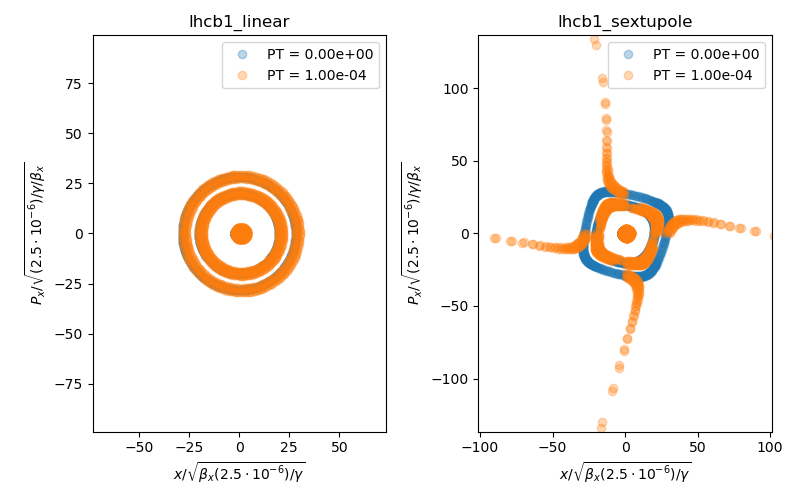

In [10]:
import itertools as itertools

sequenceNames = ['lhcb1_linear','lhcb1_sextupole']

# Importing LHC sequence :
#===========================================
mad = Madx()
mad.option(echo = True, warn = True)
for seq in sequenceNames:
    mad.call(file=f'{seq}.seq')
    
# Applying optics
mad.call(file='/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx')
# Adding beam 
mad.command.beam(particle='proton',charge=1,npart=1,energy=7000)
#===========================================


summary = pd.DataFrame()
for seq in sequenceNames:
    # Sending sequence to xsuite
    mad.input(f'''use, sequence = {seq}; 
                select,flag=makethin,slice=2,range=#s/#e;
                makethin,sequence = {seq};''')
    
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()
    alfMin = np.argmin(np.abs(twiss['alfx'][twiss['keyword']!='drift']))
    alfMinLoc = twiss[twiss['keyword']!='drift'].index[alfMin]
    
    mad.input(f'''  SEQEDIT, SEQUENCE={seq};
                    FLATTEN;
                        CYCLE, START={alfMinLoc};
                    FLATTEN;
                    ENDEDIT;''')
    
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()
    
    NParticles = 2
    
    coordinates = pd.DataFrame()
    for Jx_n,PT in itertools.product(*[[0.5e-6,2.5e-6,5e-6,500e-6,1000e-6],[0,1e-4]]):
        Jx = Jx_n/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)
        coordinates = pd.concat([coordinates,generateCoord(Jx,twiss['alfx'][0],twiss['betx'][0],NParticles,PT = PT,plane='x')])

    
    
    mad.input(MADXTools.MADTrackParticles(coordinates,NTurns = 200,saveFile = None,onepass='onepass'))

    tracked = mad.table['trackone'].dframe()   
    tracked.reset_index(inplace=True,drop=True)
    tracked.insert(0,'sequence',seq)
    
    summary = pd.concat([summary,tracked])
    summary.reset_index(inplace=True,drop=True)
    
# Plotting Normalised phase space
LHC_1sigma = 2.5e-6/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)
fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('pt')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        plt.plot(_grouped.get_group(gr)['x']/np.sqrt(twiss['betx'][0]*LHC_1sigma),_grouped.get_group(gr)['px']/np.sqrt(LHC_1sigma/twiss['betx'][0]),'o',alpha=0.3,label=f'PT = {gr:.2e}')
    plt.xlabel(r'$x/\sqrt{\beta_x (2.5\cdot 10^{-6})/\gamma}$')
    plt.ylabel(r'$P_x/\sqrt{(2.5\cdot 10^{-6})/\gamma/\beta_x }$')
    plt.legend()
    plt.axis('equal');
    plt.xlim([-100,100])
    plt.ylim([-100,100])
plt.tight_layout()

## In the y plane

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
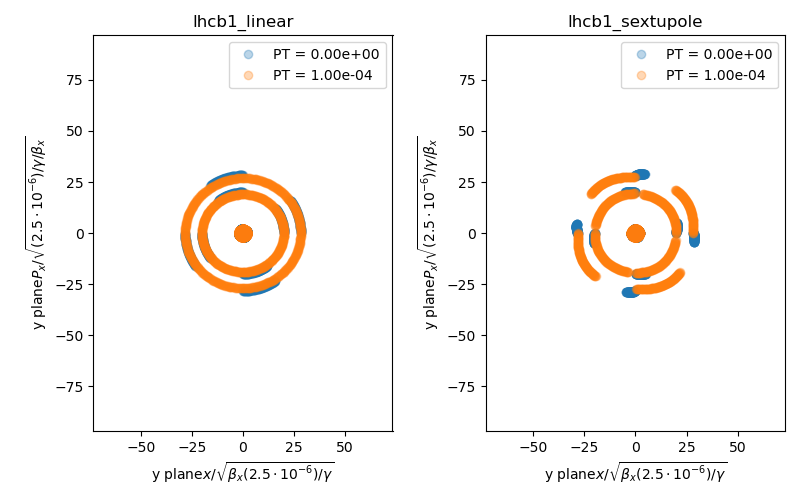

In [ ]:
import itertools as itertools

sequenceNames = ['lhcb1_linear','lhcb1_sextupole']

# Importing LHC sequence :
#===========================================
mad = Madx()
mad.option(echo = True, warn = True)
for seq in sequenceNames:
    mad.call(file=f'{seq}.seq')
    
# Applying optics
mad.call(file='/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx')
# Adding beam 
mad.command.beam(particle='proton',charge=1,npart=1,energy=7000)
#===========================================

plane = 'y'
summary = pd.DataFrame()
for seq in sequenceNames:
    # Sending sequence to xsuite
    mad.input(f'''use, sequence = {seq}; 
                select,flag=makethin,slice=2,range=#s/#e;
                makethin,sequence = {seq};''')
    
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()
    alfMin = np.argsort(np.abs(twiss[f'alf{plane}'][twiss['keyword']!='drift']))[2]
    alfMinLoc = twiss[twiss['keyword']!='drift'].index[alfMin]
    
    mad.input(f'''  SEQEDIT, SEQUENCE={seq};
                    FLATTEN;
                        CYCLE, START={alfMinLoc};
                    FLATTEN;
                    ENDEDIT;''')
    
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()
    
    NParticles = 2
    
    coordinates = pd.DataFrame()
    for Jx_n,PT in itertools.product(*[[0.5e-6,2.5e-6,5e-6,500e-6,1000e-6],[0,1e-4]]):
        Jx = Jx_n/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)
        coordinates = pd.concat([coordinates,generateCoord(Jx,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0],NParticles,PT = PT,plane=plane)])

    
    
    mad.input(MADXTools.MADTrackParticles(coordinates,NTurns = 200,saveFile = None,onepass='onepass'))

    tracked = mad.table['trackone'].dframe()   
    tracked.reset_index(inplace=True,drop=True)
    tracked.insert(0,'sequence',seq)
    
    summary = pd.concat([summary,tracked])
    summary.reset_index(inplace=True,drop=True)
    
# Plotting Normalised phase space
LHC_1sigma = 2.5e-6/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)
fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('pt')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        plt.plot(_grouped.get_group(gr)[f'{plane}']/np.sqrt(twiss[f'bet{plane}'][0]*LHC_1sigma),_grouped.get_group(gr)[f'p{plane}']/np.sqrt(LHC_1sigma/twiss[f'bet{plane}'][0]),'o',alpha=0.3,label=f'PT = {gr:.2e}')
    plt.xlabel(f'{plane} plane'+r'$x/\sqrt{\beta_x (2.5\cdot 10^{-6})/\gamma}$')
    plt.ylabel(f'{plane} plane'+r'$P_x/\sqrt{(2.5\cdot 10^{-6})/\gamma/\beta_x }$')
    plt.legend()
    plt.axis('equal');
    plt.xlim([-100,100])
    plt.ylim([-100,100])
plt.tight_layout()

  0%|          | 0/2 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
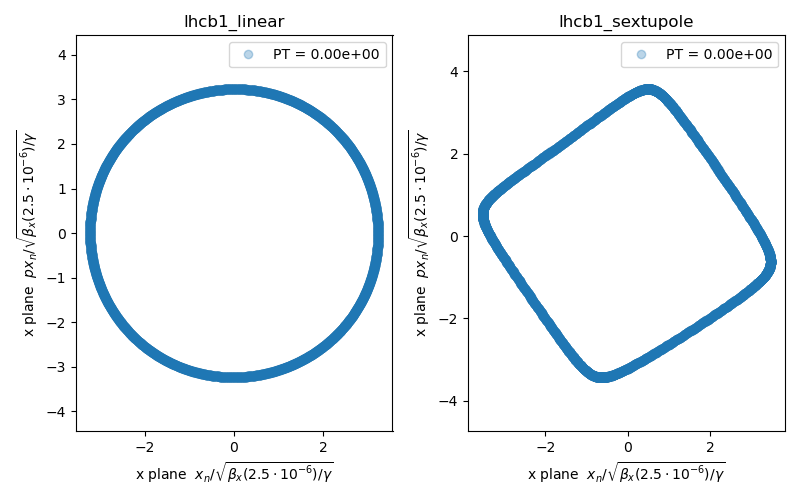

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
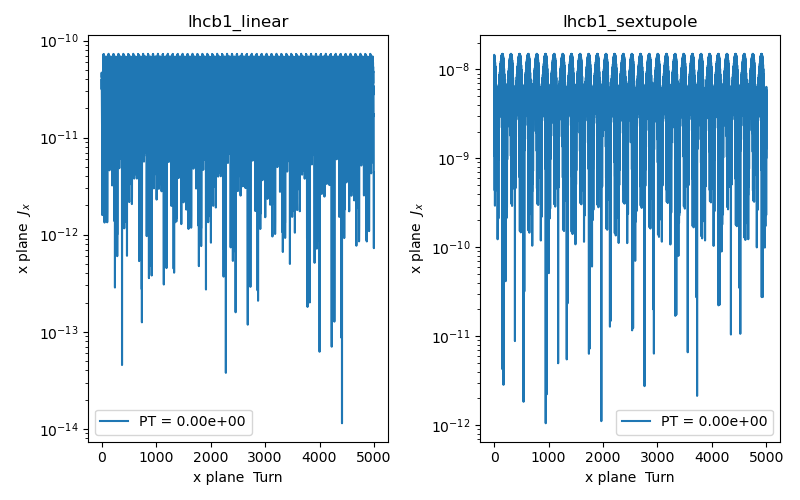

In [35]:
import itertools as itertools
from tqdm.notebook import tqdm
import Backend.BeamPhysics as BP

sequenceNames = ['lhcb1_linear','lhcb1_sextupole']

# Importing LHC sequence :
#===========================================
mad = Madx()
mad.option(echo = True, warn = True)
for seq in sequenceNames:
    mad.call(file=f'{seq}.seq')
    
# Applying optics
mad.call(file='/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx')
# Adding beam 
mad.command.beam(particle='proton',charge=1,npart=1,energy=7000)
#===========================================

plane = 'x'
summary = pd.DataFrame()
for seq in tqdm(sequenceNames):
    # Sending sequence to xsuite
    mad.input(f'''use, sequence = {seq}; 
                select,flag=makethin,slice=2,range=#s/#e;
                makethin,sequence = {seq};''')
    
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()

    
    
    mad.input(f'''  SEQEDIT, SEQUENCE={seq};
                    FLATTEN;
                        CYCLE, START=ip3;
                    FLATTEN;
                    ENDEDIT;''')
    
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()
    
    NParticles = 1
    
    coordinates = pd.DataFrame()
    for Jx_n,PT in itertools.product(*[[1600e-6],[0]]):
        Jx = Jx_n/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)
        coordinates = pd.concat([coordinates,generateCoord(Jx,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0],NParticles,PT = PT,plane=plane)])

    
    
    mad.input(MADXTools.MADTrackParticles(coordinates,NTurns = int(5e3),saveFile = None,onepass='onepass'))

    tracked = mad.table['trackone'].dframe()   
    tracked.reset_index(inplace=True,drop=True)
    tracked.insert(0,'sequence',seq)
    tracked.insert(0,'ID',list(zip(tracked['sequence'],tracked['number']))) 
    
    
    summary = pd.concat([summary,tracked])
    summary.reset_index(inplace=True,drop=True)


    
# Plotting Normalised phase space
LHC_1sigma = 2.5e-6/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)


    
# Plotting Normalised phase space
LHC_1sigma =  np.sqrt(twiss[f'bet{plane}'][0]*2.5e-6/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass))
fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('pt')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        x,px = np.array(_grouped.get_group(gr)[f'{plane}']),np.array(_grouped.get_group(gr)[f'p{plane}'])
        x_n,px_n = BP.normCoordinates(x,px,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0])
        
        plt.plot(x_n/LHC_1sigma,px_n/LHC_1sigma,'o',alpha=0.3,label=f'PT = {gr:.2e}')
    plt.xlabel(f'{plane} plane  '+r'$x_n/\sqrt{\beta_x (2.5\cdot 10^{-6})/\gamma}$')
    plt.ylabel(f'{plane} plane  '+r'$px_n/\sqrt{\beta_x (2.5\cdot 10^{-6})/\gamma}$')
    plt.legend()
    plt.axis('equal');
    #plt.xlim([-100,100])
    #plt.ylim([-100,100])
    
plt.tight_layout()


# Plotting increase in action
fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('pt')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        x,px = np.array(_grouped.get_group(gr)[f'{plane}']),np.array(_grouped.get_group(gr)[f'p{plane}'])
        J_x = BP.getAction(x,px,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0])
        
        plt.plot(np.abs(np.diff(J_x)),label=f'PT = {gr:.2e}')
    plt.yscale('log')
    plt.xlabel(f'{plane} plane  '+r'Turn')
    plt.ylabel(f'{plane} plane  '+r'$J_x$')
    plt.legend()
    #plt.xlim([-100,100])
    #plt.ylim([-100,100])
    
plt.tight_layout()

In [28]:
plt.close('all')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
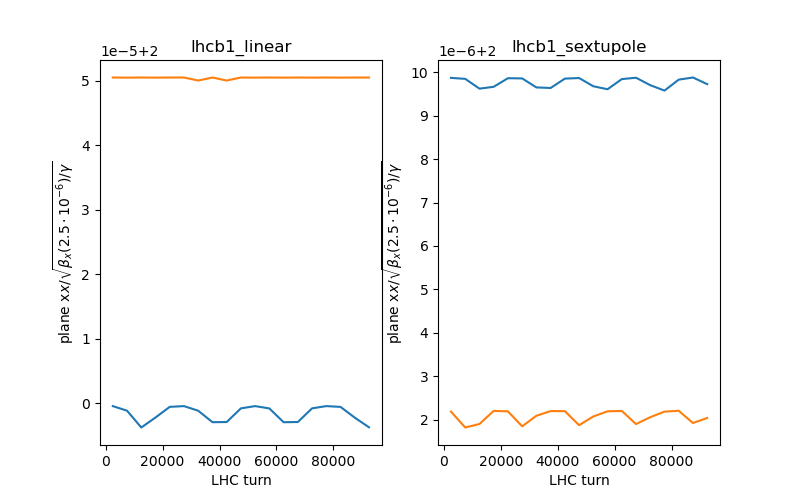

In [32]:
from scipy.signal import hilbert, chirp


fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('pt')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        t = _grouped.get_group(gr)['turn']
        signal = _grouped.get_group(gr)[plane]/np.sqrt(twiss[f'bet{plane}'][0]*LHC_1sigma)
        
        bins = np.arange(t.iloc[0],t.iloc[-1],5000)
        digitized = np.digitize(t,bins)
        bin_max = np.array([signal[digitized == i].max() for i in range(1, len(bins))])
        bin_times = bins[:-1] + np.diff(bins)/2
        
        plt.plot(bin_times, bin_max, label='envelope')
    plt.ylabel(f'plane {plane}' + r'$x/\sqrt{\beta_x (2.5\cdot 10^{-6})/\gamma}$')
    plt.xlabel(r'LHC turn')
    
    


In [16]:
from scipy.signal import hilbert, chirp
%matplotlib widget

fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('pt')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        t = _grouped.get_group(gr)['turn']
        signal = _grouped.get_group(gr)[plane]/np.sqrt(twiss[f'bet{plane}'][0]*LHC_1sigma)
        
        bins = np.arange(t.iloc[0],t.iloc[-1],5000)
        digitized = np.digitize(t,bins)
        bin_max = np.array([signal[digitized == i].max() for i in range(1, len(bins))])
        bin_times = bins[:-1] + np.diff(bins)/2
        
        plt.plot(t[signal>6.2], signal[signal>6.2], label='envelope')
    #plt.ylabel(f'plane {plane}' + r'$x/\sqrt{\beta_x (2.5\cdot 10^{-6})/\gamma}$')
    #plt.xlabel(r'LHC turn')
    plt.ylim([5.5,6.5])
    
    


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [38]:
summary.groupby('ID').count()


sequence  number  turn     x    px     y    py     t  \
ID                                                                             
(lhcb1_linear, 1.0)         1001    1001  1001  1001  1001  1001  1001  1001   
(lhcb1_sextupole, 1.0)      1001    1001  1001  1001  1001  1001  1001  1001   

                          pt     s     e  
ID                                        
(lhcb1_linear, 1.0)     1001  1001  1001  
(lhcb1_sextupole, 1.0)  1001  1001  1001

In [13]:
from scipy import signal
from scipy.fft import fftshift
def spectrogram(particle):
    f, t, Sxx = signal.spectrogram(x, fs)
    plt.pcolormesh(t, f, Sxx,  cmap='gray_r', shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
        
    
    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
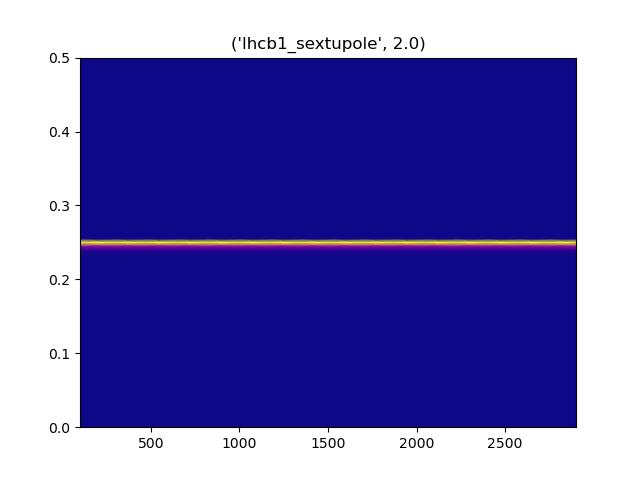

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
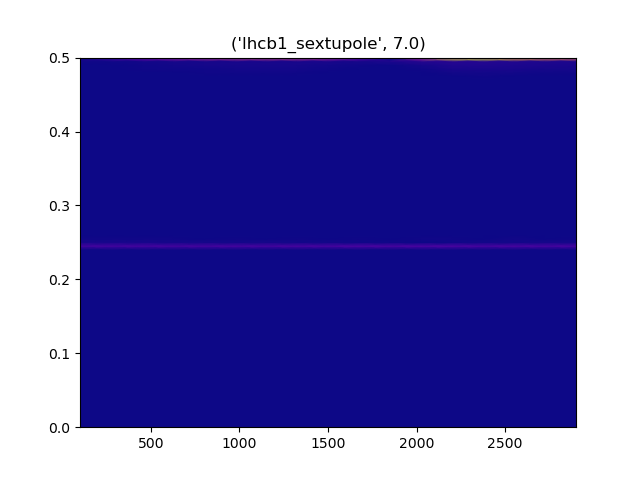

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
_grouped = summary.groupby('ID')

plt.close('all')
for gr in list(_grouped.groups.keys())[10:]:
    x,time = _grouped.get_group(gr)[['x','turn']].T.values
    f, t, Sxx = signal.spectrogram(x, fs=1,nperseg=200)
    plt.figure()
    plt.title(gr)
    plt.pcolormesh(t, f, Sxx,  cmap='plasma', shading='gouraud')

# Increase in action?

In [9]:
for seq in tqdm(sequenceNames[:1]):
    # Sending sequence to xsuite
    mad.input(f'''use, sequence = {seq}; 
                select,flag=makethin,slice=2,range=#s/#e;
                makethin,sequence = {seq};''')
    
    mad.sequence[seq].use()

    mad.input(f'''  SEQEDIT, SEQUENCE={seq};
                    FLATTEN;
                        CYCLE, START=ip3;
                    FLATTEN;
                    ENDEDIT;''')
    
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()
    

  0%|          | 0/1 [00:00<?, ?it/s]

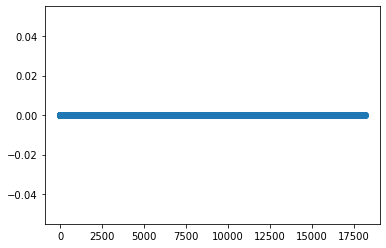

In [10]:
plt.figure()
plt.plot(np.array(twiss['k2l']),'-o')

In [3]:
coordinates

t            Jx         x        px
0  1.5  1.675261e-10  0.000203 -0.000004
0  1.5  1.675261e-09  0.000641 -0.000013
0  1.5  1.675261e-08  0.002026 -0.000040
0  1.5  1.675261e-07  0.006408 -0.000126
0  1.5  1.675261e-06  0.020265 -0.000400

  0%|          | 0/2 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
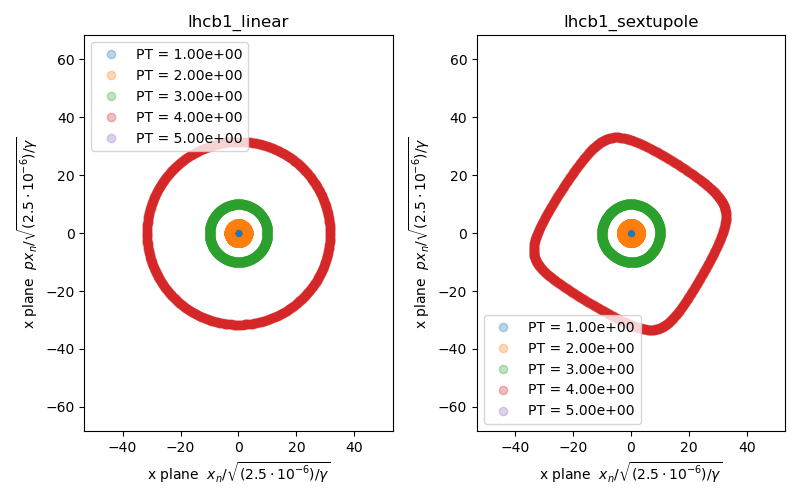

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
import itertools as itertools
from tqdm.notebook import tqdm
import Backend.BeamPhysics as BP

sequenceNames = ['lhcb1_linear','lhcb1_sextupole']

# Importing LHC sequence :
#===========================================
mad = Madx()
mad.option(echo = True, warn = True)
for seq in sequenceNames:
    mad.call(file=f'{seq}.seq')
    
# Applying optics
mad.call(file='/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx')
# Adding beam 
mad.command.beam(particle='proton',charge=1,npart=1,energy=7000)
#===========================================

plane = 'x'
summary = pd.DataFrame()
for seq in tqdm(sequenceNames):
    # Sending sequence to xsuite
    mad.input(f'''use, sequence = {seq}; 
                select,flag=makethin,slice=2,range=#s/#e;
                makethin,sequence = {seq};''')
    
    mad.sequence[seq].use()

    mad.input(f'''  SEQEDIT, SEQUENCE={seq};
                    FLATTEN;
                        CYCLE, START=ip1;
                    FLATTEN;
                    ENDEDIT;''')
    
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()
    
    NParticles = 1    
    coordinates = pd.DataFrame()
    for Jx_n,PT in itertools.product(*[2.5/2*np.logspace(-6,-2,5),[0]]):
        Jx = Jx_n/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)
        coordinates = pd.concat([coordinates,BP.generateCoord(Jx,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0],NParticles,plane=plane)])
    
    coordinates.insert(0,'t',1.5*np.ones(len(coordinates)))
    
    mad.input(MADXTools.MADTrackParticles(coordinates,NTurns = int(1e3),saveFile = None,onepass='onepass'))

    tracked = mad.table['trackone'].dframe()   
    tracked.reset_index(inplace=True,drop=True)
    tracked.insert(0,'sequence',seq)
    tracked.insert(0,'ID',list(zip(tracked['sequence'],tracked['number'])))
    
    
    summary = pd.concat([summary,tracked])
    summary.reset_index(inplace=True,drop=True)


    

    
# Plotting Normalised phase space
LHC_1sigma =  np.sqrt(2.5e-6/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass))

fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('number')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        x,px = np.array(_grouped.get_group(gr)[f'{plane}']),np.array(_grouped.get_group(gr)[f'p{plane}'])
        x_n,px_n = BP.normCoordinates(x,px,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0])
        
        plt.plot(x_n/LHC_1sigma,px_n/LHC_1sigma,'o',alpha=0.3,label=f'PT = {gr:.2e}')
    plt.xlabel(f'{plane} plane  '+r'$x_n/\sqrt{(2.5\cdot 10^{-6})/\gamma}$')
    plt.ylabel(f'{plane} plane  '+r'$px_n/\sqrt{(2.5\cdot 10^{-6})/\gamma}$')
    plt.legend()
    plt.axis('equal');
    plt.xlim([-50,50])
    plt.ylim([-50,50])
    
plt.tight_layout()


# Plotting increase in action
fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('number')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        x,px = np.array(_grouped.get_group(gr)[f'{plane}']),np.array(_grouped.get_group(gr)[f'p{plane}'])
        J_x = BP.getAction(x,px,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0])
        
        plt.plot(np.sqrt(2*J_x)/LHC_1sigma,label=f'ID {gr}')
    plt.yscale('log')
    plt.xlabel(f'{plane} plane  '+r'Turn')
    plt.ylabel(f'{plane} plane  '+r'$J_x$')
    #plt.legend()
    #plt.xlim([-100,100])
    #plt.ylim([-100,100])
    
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
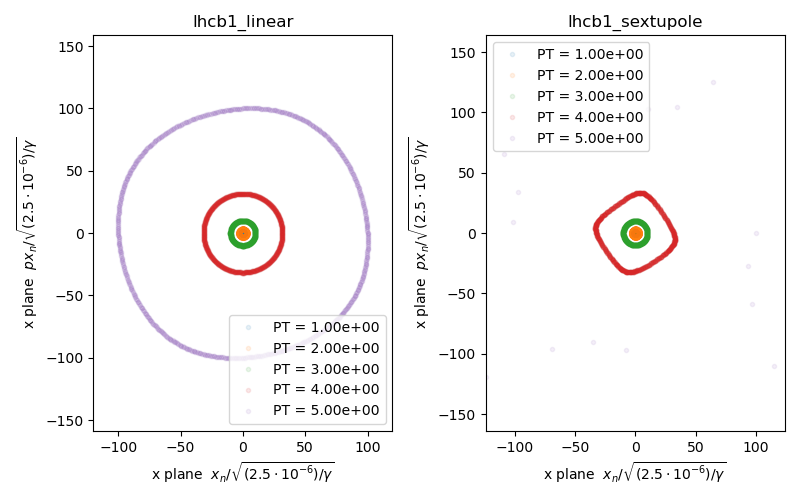

In [15]:
# Plotting Normalised phase space
%matplotlib widget
LHC_1sigma =  np.sqrt(2.5e-6/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass))

fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('number')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        x,px = np.array(_grouped.get_group(gr)[f'{plane}']),np.array(_grouped.get_group(gr)[f'p{plane}'])
        x_n,px_n = BP.normCoordinates(x,px,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0])
        
        plt.plot(x_n/LHC_1sigma,px_n/LHC_1sigma,'.',alpha=0.1,label=f'PT = {gr:.2e}')
    plt.xlabel(f'{plane} plane  '+r'$x_n/\sqrt{(2.5\cdot 10^{-6})/\gamma}$')
    plt.ylabel(f'{plane} plane  '+r'$px_n/\sqrt{(2.5\cdot 10^{-6})/\gamma}$')
    plt.legend()
    plt.axis('equal');
    plt.xlim([-120,120])
    plt.ylim([-120,120])
    
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
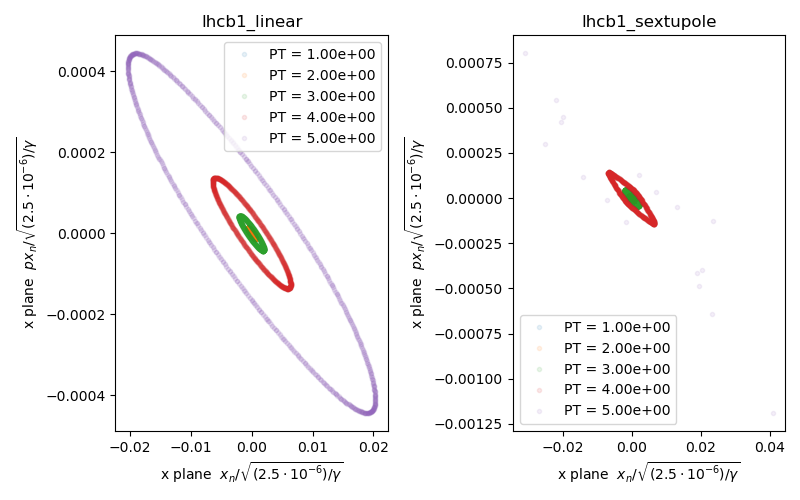

In [18]:
%matplotlib widget
LHC_1sigma =  np.sqrt(2.5e-6/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass))

fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('number')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        x,px = np.array(_grouped.get_group(gr)[f'{plane}']),np.array(_grouped.get_group(gr)[f'p{plane}'])
        x_n,px_n = BP.normCoordinates(x,px,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0])
        
        plt.plot(x,px,'.',alpha=0.1,label=f'PT = {gr:.2e}')
    plt.xlabel(f'{plane} plane  '+r'$x_n/\sqrt{(2.5\cdot 10^{-6})/\gamma}$')
    plt.ylabel(f'{plane} plane  '+r'$px_n/\sqrt{(2.5\cdot 10^{-6})/\gamma}$')
    plt.legend()
    #plt.axis('equal');
    #plt.xlim([-120,120])
    #plt.ylim([-120,120])
    
plt.tight_layout()

In [20]:
# Plotting increase in action
fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('number')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        x,px = np.array(_grouped.get_group(gr)[f'{plane}']),np.array(_grouped.get_group(gr)[f'p{plane}'])
        J_x = BP.getAction(x,px,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0])
        
        plt.plot(np.sqrt(2*J_x)/LHC_1sigma,label=f'ID {gr}')
    #plt.yscale('log')
    plt.xlabel(f'Turn',fontsize=16)
    plt.ylabel(r'Amplitude $[\sigma] \quad \left(\frac{\sqrt{2J_x}}{\sqrt{2.5\times 10^{-6}/\gamma}}\right)$',fontsize=16)
    #plt.legend()
    #plt.xlim([-100,100])
    plt.ylim([-1,110])
    
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

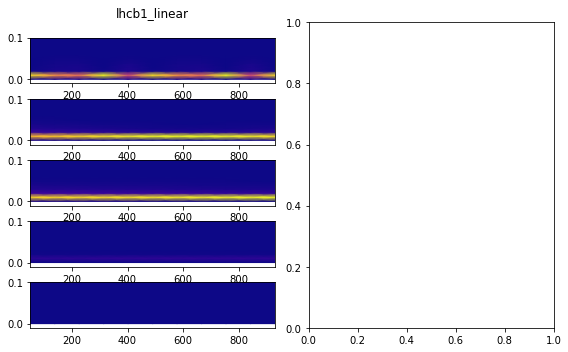

In [20]:
from scipy import signal
from scipy.fft import fftshift

#sequenceNames
fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames[:1],axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('number')
    plt.sca(ax)
    plt.title(seq)
    
    y0 = 0
    plt.axis('off')
    for gr in list(_grouped.groups.keys()):
        #x,px = np.array(_grouped.get_group(gr)[f'{plane}']),np.array(_grouped.get_group(gr)[f'p{plane}'])
        J_x = BP.getAction(x,px,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0])
        
        axin = ax.inset_axes([0, y0, 1,0.15])
        y0 += 1/len(list(_grouped.groups.keys()))

        x,px,time = _grouped.get_group(gr)[['x','px','turn']].T.values
        J_x = BP.getAction(x,px,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0])
        
        f, t, Sxx = signal.spectrogram(J_x, fs=1,nperseg=100)
        
        axin.pcolormesh(t, f, Sxx,  cmap='plasma', shading='gouraud')
        axin.set_ylim([-0.01,0.1])

        
    #plt.yscale('log')
    plt.xlabel(f'{plane} plane  '+r'Turn')
    plt.ylabel(f'{plane} plane  '+r'$J_x$')

    #plt.xlim([-100,100])
    #plt.ylim([-100,100])
    
plt.tight_layout()

(0.0, 0.05)

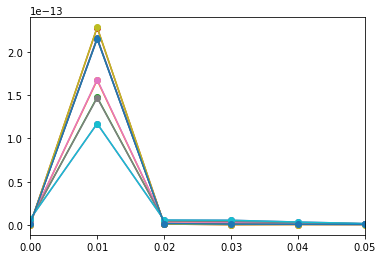

In [31]:
plt.figure()
plt.plot(f,Sxx[:,:],'-o')
plt.xlim([0,0.05])

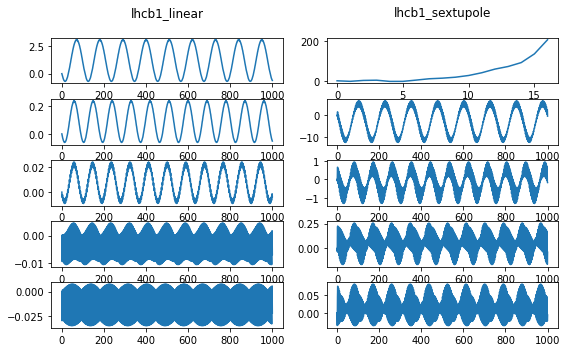

In [18]:
# Plotting increase in action
fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('number')
    plt.sca(ax)
    plt.title(seq)
    
    y0 = 0
    plt.axis('off')
    for gr in list(_grouped.groups.keys()):
        x,px = np.array(_grouped.get_group(gr)[f'{plane}']),np.array(_grouped.get_group(gr)[f'p{plane}'])
        J_x = BP.getAction(x,px,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0])
        
        axin = ax.inset_axes([0, y0, 1,0.15])
        y0 += 1/len(list(_grouped.groups.keys()))

        action = np.sqrt(2*J_x)/LHC_1sigma
        axin.plot((action-action[0])/action[0]*100)
        #axin.set_ylim([-4,4])

        
    #plt.yscale('log')
    plt.xlabel(f'{plane} plane  '+r'Turn')
    plt.ylabel(f'{plane} plane  '+r'$J_x$')

    #plt.xlim([-100,100])
    #plt.ylim([-100,100])
    
plt.tight_layout()

In [124]:
J_x

array([1.67526132e-05,            nan])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


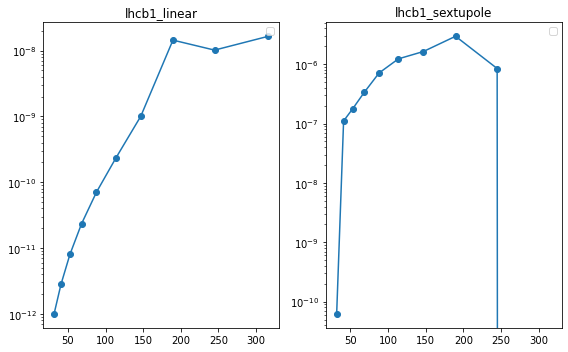

In [129]:
# Plotting increase in action
LHC_1sigma =  np.sqrt(2.5e-6/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass))
fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('number')
    plt.sca(ax)
    plt.title(seq)
    rate = []
    J0 = []
    for gr in list(_grouped.groups.keys()):
        x,px = np.array(_grouped.get_group(gr)[f'{plane}']),np.array(_grouped.get_group(gr)[f'p{plane}'])
        J_x = BP.getAction(x,px,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0])
        
        rate.append((np.max(J_x[~np.isnan(J_x)])-np.min(J_x[~np.isnan(J_x)]))/np.max(_grouped.get_group(gr)['turn'])) 
        J0.append(J_x[0])
    
    plt.plot(np.sqrt(2*np.array(J0))/LHC_1sigma,rate,'-o')
    plt.yscale('log')
    #plt.xlabel(f'{plane} plane  '+r'Turn')
    #plt.ylabel(f'{plane} plane  '+r'$J_x$')
    plt.legend()
    #plt.xlim([-100,100])
    #plt.ylim([-100,100])
    
plt.tight_layout()

In [11]:
plt.figuresummary

ID         sequence  number    turn         x  \
0        (lhcb1_linear, 1.0)     lhcb1_linear     1.0     0.0  0.000203   
1        (lhcb1_linear, 2.0)     lhcb1_linear     2.0     0.0  0.000641   
2        (lhcb1_linear, 3.0)     lhcb1_linear     3.0     0.0  0.002026   
3        (lhcb1_linear, 4.0)     lhcb1_linear     4.0     0.0  0.006408   
4        (lhcb1_linear, 5.0)     lhcb1_linear     5.0     0.0  0.020265   
...                      ...              ...     ...     ...       ...   
9022  (lhcb1_sextupole, 4.0)  lhcb1_sextupole     4.0   999.0 -0.000141   
9023  (lhcb1_sextupole, 1.0)  lhcb1_sextupole     1.0  1000.0  0.000093   
9024  (lhcb1_sextupole, 2.0)  lhcb1_sextupole     2.0  1000.0  0.000271   
9025  (lhcb1_sextupole, 3.0)  lhcb1_sextupole     3.0  1000.0  0.000115   
9026  (lhcb1_sextupole, 4.0)  lhcb1_sextupole     4.0  1000.0  0.006386   

            px    y   py         t   pt           s    e  
0    -0.000004  0.0  0.0  1.500000  0.0      0.0000  0.0  
1    -0.000013  0.0  0.0  1.500000  0.0      0.0000  0.0  
2    -0.000040  0.0  0.0  1.500000  0.0      0.0000  0.0  
3    -0.000126  0.0  0.0  1.500000  0.0      0.0000  0.0  
4    -0.000400  0.0  0.0  1.500000  0.0      0.0000  0.0  
...        ...  ...  ...       ...  ...         ...  ...  
9022  0.000056  0.0  0.0  1.512653  0.0  26658.8832  0.0  
9023 -0.000003  0.0  0.0  1.500012  0.0  26658.8832  0.0  
9024 -0.000010  0.0  0.0  1.500129  0.0  26658.8832  0.0  
9025 -0.000019  0.0  0.0  1.501306  0.0  26658.8832  0.0  
9026 -0.000125  0.0  0.0  1.512833  0.0  26658.8832  0.0  

[9027 rows x 12 columns]

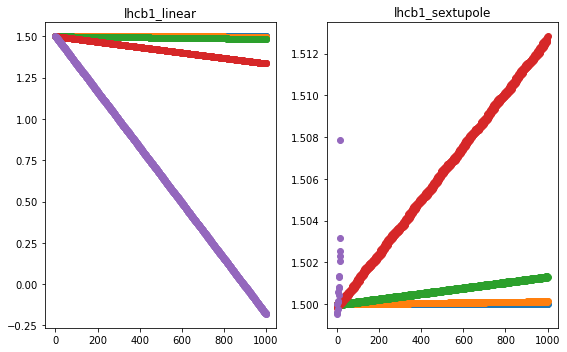

In [146]:
# Plotting increase in action
fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('number')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        t_var = np.array(_grouped.get_group(gr)[f't'])
        #J_x = BP.getAction(x,px,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0])
        
        plt.plot(t_var,'o',label=f'ID {gr}')
    #plt.yscale('log')
    #plt.xlabel(f'Turn',fontsize=16)
    #plt.ylabel(r'Amplitude $[\sigma] \quad \left(\frac{\sqrt{2J_x}}{\sqrt{2.5\times 10^{-6}/\gamma}}\right)$',fontsize=16)
    #plt.legend()
    #plt.xlim([-100,100])
    #plt.ylim([-1,110])
    
plt.tight_layout()

In [139]:
t

(array([ 0.00000000e+00, -3.99960886e-04, -4.76152901e-04, -2.35832187e-04,
         5.89027848e-04,  1.27252462e-04,  8.71228322e-05,  4.42146912e-04,
         1.29494954e-03,  7.71015132e-04,  8.04364584e-04,  1.35663607e-03,
         2.56244125e-03,  2.04442045e-03,  2.30807515e-03,  3.18081574e-03,
         7.85315300e-03,             nan]),)

In [37]:
np.array(J0)*(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)

np.sqrt(2.5e-6/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass))

array([0.0017    , 0.00171633, 0.00173265, 0.00174898, 0.00176531,
       0.00178163, 0.00179796, 0.00181429, 0.00183061, 0.00184694,
       0.00186327, 0.00187959, 0.00189592, 0.00191224, 0.00192857,
       0.0019449 , 0.00196122, 0.00197755, 0.00199388, 0.0020102 ,
       0.00202653, 0.00204286, 0.00205918, 0.00207551, 0.00209184,
       0.00210816, 0.00212449, 0.00214082, 0.00215714, 0.00217347,
       0.0021898 , 0.00220612, 0.00222245, 0.00223878, 0.0022551 ,
       0.00227143, 0.00228776, 0.00230408, 0.00232041, 0.00233673,
       0.00235306, 0.00236939, 0.00238571, 0.00240204, 0.00241837,
       0.00243469, 0.00245102, 0.00246735, 0.00248367, 0.0025    ])

In [20]:
_grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('number')

ID = 11

_grouped.get_group(ID)

ID         sequence  number   turn         x  \
20030  (lhcb1_sextupole, 11.0)  lhcb1_sextupole    11.0    0.0  0.007611   
20050  (lhcb1_sextupole, 11.0)  lhcb1_sextupole    11.0    1.0 -0.000030   
20070  (lhcb1_sextupole, 11.0)  lhcb1_sextupole    11.0    2.0 -0.007746   
20090  (lhcb1_sextupole, 11.0)  lhcb1_sextupole    11.0    3.0 -0.000359   
20110  (lhcb1_sextupole, 11.0)  lhcb1_sextupole    11.0    4.0  0.007450   
...                        ...              ...     ...    ...       ...   
24694  (lhcb1_sextupole, 11.0)  lhcb1_sextupole    11.0  258.0 -0.026535   
24705  (lhcb1_sextupole, 11.0)  lhcb1_sextupole    11.0  259.0 -0.030228   
24716  (lhcb1_sextupole, 11.0)  lhcb1_sextupole    11.0  260.0  0.023958   
24727  (lhcb1_sextupole, 11.0)  lhcb1_sextupole    11.0  261.0  0.039523   
24738  (lhcb1_sextupole, 11.0)  lhcb1_sextupole    11.0  262.0       NaN   

             px    y   py         t   pt           s    e  
20030 -0.000150  0.0  0.0  0.000000  0.0      0.0000  0.0  
20050 -0.000061  0.0  0.0 -0.000113  0.0  26658.8832  0.0  
20070  0.000151  0.0  0.0 -0.000231  0.0  26658.8832  0.0  
20090  0.000070  0.0  0.0 -0.000148  0.0  26658.8832  0.0  
20110 -0.000145  0.0  0.0  0.000073  0.0  26658.8832  0.0  
...         ...  ...  ...       ...  ...         ...  ...  
24694  0.000331  0.0  0.0  0.008841  0.0  26658.8832  0.0  
24705  0.000796  0.0  0.0  0.009100  0.0  26658.8832  0.0  
24716 -0.000139  0.0  0.0  0.009999  0.0  26658.8832  0.0  
24727 -0.001168  0.0  0.0  0.014445  0.0  26658.8832  0.0  
24738       NaN  NaN  NaN       NaN  0.0  26658.8832  0.0  

[263 rows x 12 columns]

### XSuite

In [21]:
import itertools as itertools
from tqdm.notebook import tqdm
import xline as xl
import xobjects as xo
import xtrack as xt
import xpart as xp


sequenceNames = ['lhcb1_linear','lhcb1_sextupole']

# Importing LHC sequence :
#===========================================
mad = Madx()
mad.option(echo = True, warn = True)
for seq in sequenceNames:
    mad.call(file=f'{seq}.seq')
    
# Applying optics
mad.call(file='/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx')
# Adding beam 
mad.command.beam(particle='proton',charge=1,npart=1,energy=7000)
#===========================================

plane = 'x'
summary = pd.DataFrame()
for seq in tqdm(sequenceNames):
    # Sending sequence to xsuite
    mad.input(f'''use, sequence = {seq}; 
                select,flag=makethin,slice=2,range=#s/#e;
                makethin,sequence = {seq};''')
    
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()
    #in y
    #alfMin = np.argsort(np.abs(twiss[f'alf{plane}'][twiss['keyword']!='drift']))[2]
    
    #in x
    alfMin = np.argmin(np.abs(twiss['alfx'][twiss['keyword']!='drift']))
    alfMinLoc = twiss[twiss['keyword']!='drift'].index[alfMin]
    
    mad.input(f'''  SEQEDIT, SEQUENCE={seq};
                    FLATTEN;
                        CYCLE, START={alfMinLoc};
                    FLATTEN;
                    ENDEDIT;''')
    
    mad.sequence[seq].use()
    mad.twiss()
    twiss = mad.table['twiss'].dframe()
    
    
   
    NParticles = 1
    
    coordinates = pd.DataFrame()
    for Jx_n,PT in itertools.product(*[[50e-6],[0]]):
        Jx = Jx_n/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)
        coordinates = pd.concat([coordinates,generateCoord(Jx,twiss[f'alf{plane}'][0],twiss[f'bet{plane}'][0],NParticles,PT = PT,plane=plane)])

    
    
    
    #=============
    
    xsequence = xl.Line.from_madx_sequence(mad.sequence[seq])
    context = xo.ContextCpu()

    # Setting up the tracker
    tracker = xt.Tracker(_context=context,sequence=xsequence)
    particles = xt.Particles(_context=context,
                            p0c=mad.sequence[seq].beam.pc*1e9,
                            x=coordinates['x'],
                            px=coordinates['px'],
                            pt = coordinates['pt']
                            )

    

    ## Track (saving turn-by-turn data)
    n_turns = int(5e6)
    tracker.track(particles, num_turns=n_turns,turn_by_turn_monitor=True)
    
    #================
    
    #CONVERT TO PANDAS
    tracked = pd.DataFrame(tracker.record_last_track.to_dict()['data'])
    tracked = tracked[['at_turn','particle_id','x','px','y','py','zeta','delta']]
    tracked.rename(columns={"at_turn": "turn",'particle_id':'number', "zeta": "t", "delta": "pt"},inplace=True)

    #Summary
    tracked.insert(0,'sequence',seq)
    tracked.insert(0,'ID',list(zip(tracked['sequence'],tracked['number']))) 
    summary = pd.concat([summary,tracked])
    summary.reset_index(inplace=True,drop=True)

    
# Plotting Normalised phase space
LHC_1sigma = 2.5e-6/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)


fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('pt')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        plt.plot(_grouped.get_group(gr)['turn'],_grouped.get_group(gr)[plane]/np.sqrt(twiss[f'bet{plane}'][0]*LHC_1sigma),'-',alpha=0.3,)
    plt.ylabel(f'plane {plane}' + r'$x/\sqrt{\beta_x (2.5\cdot 10^{-6})/\gamma}$')
    plt.xlabel(r'LHC turn')

plt.tight_layout()

  0%|          | 0/2 [00:00<?, ?it/s]

generating ./e4542e919eb149bc97a80b741a5e1237.c
the current directory is '/home/pbelange/LHC_testbench'
running build_ext
building 'e4542e919eb149bc97a80b741a5e1237' extension
gcc -pthread -B /home/pbelange/Apps/miniconda3/compiler_compat -Wl,--sysroot=/ -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/pbelange/Apps/miniconda3/include -fPIC -O2 -isystem /home/pbelange/Apps/miniconda3/include -fPIC -I/home/pbelange/Apps/miniconda3/include/python3.9 -c e4542e919eb149bc97a80b741a5e1237.c -o ./e4542e919eb149bc97a80b741a5e1237.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/pbelange/Apps/miniconda3/compiler_compat -Wl,--sysroot=/ -shared -Wl,-rpath,/home/pbelange/Apps/miniconda3/lib -Wl,-rpath-link,/home/pbelange/Apps/miniconda3/lib -L/home/pbelange/Apps/miniconda3/lib -Wl,-rpath,/home/pbelange/Apps/miniconda3/lib -Wl,-rpath-link,/home/pbelange/Apps/miniconda3/lib -L/home/pbelange/Apps/miniconda3/lib ./e4542e919eb149bc97a80b741a5e1237.o -o ./e4542e919e

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
summary

ID         sequence  turn  number         x  \
0        (lhcb1_linear, 0)     lhcb1_linear     0       0  0.000660   
1        (lhcb1_linear, 0)     lhcb1_linear     1       0  0.000012   
2        (lhcb1_linear, 0)     lhcb1_linear     2       0 -0.000659   
3        (lhcb1_linear, 0)     lhcb1_linear     3       0 -0.000035   
4        (lhcb1_linear, 0)     lhcb1_linear     4       0  0.000658   
...                    ...              ...   ...     ...       ...   
1995  (lhcb1_sextupole, 0)  lhcb1_sextupole   995       0  0.000643   
1996  (lhcb1_sextupole, 0)  lhcb1_sextupole   996       0  0.000162   
1997  (lhcb1_sextupole, 0)  lhcb1_sextupole   997       0 -0.000635   
1998  (lhcb1_sextupole, 0)  lhcb1_sextupole   998       0 -0.000196   
1999  (lhcb1_sextupole, 0)  lhcb1_sextupole   999       0  0.000631   

                px    y   py             t   pt  
0     8.398285e-09  0.0  0.0  0.000000e+00  0.0  
1    -2.031105e-05  0.0  0.0 -2.672523e-05  0.0  
2    -7.296999e-07  0.0  0.0 -1.386789e-05  0.0  
3     2.028514e-05  0.0  0.0 -5.834049e-07  0.0  
4     1.450081e-06  0.0  0.0 -2.488366e-05  0.0  
...            ...  ...  ...           ...  ...  
1995  4.806617e-06  0.0  0.0  5.367913e-04  0.0  
1996 -1.973027e-05  0.0  0.0  5.130121e-04  0.0  
1997 -5.535058e-06  0.0  0.0  5.278571e-04  0.0  
1998  1.943818e-05  0.0  0.0  5.519133e-04  0.0  
1999  6.176785e-06  0.0  0.0  5.403116e-04  0.0  

[2000 rows x 10 columns]

In [15]:
LHC_1sigma = 2.5e-6/(1+ mad.sequence[seq].beam.energy/mad.globals.pmass)

In [16]:
from scipy.signal import hilbert, chirp
%matplotlib widget

fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('pt')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        t = _grouped.get_group(gr)['turn']
        signal = _grouped.get_group(gr)[plane]/np.sqrt(twiss[f'bet{plane}'][0]*LHC_1sigma)
        
        bins = np.arange(t.iloc[0],t.iloc[-1],5000)
        digitized = np.digitize(t,bins)
        bin_max = np.array([signal[digitized == i].max() for i in range(1, len(bins))])
        bin_times = bins[:-1] + np.diff(bins)/2
        
        plt.plot(t[signal>6.2], signal[signal>6.2], label='envelope')
    #plt.ylabel(f'plane {plane}' + r'$x/\sqrt{\beta_x (2.5\cdot 10^{-6})/\gamma}$')
    #plt.xlabel(r'LHC turn')
    plt.ylim([5.5,6.5])
    
    


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
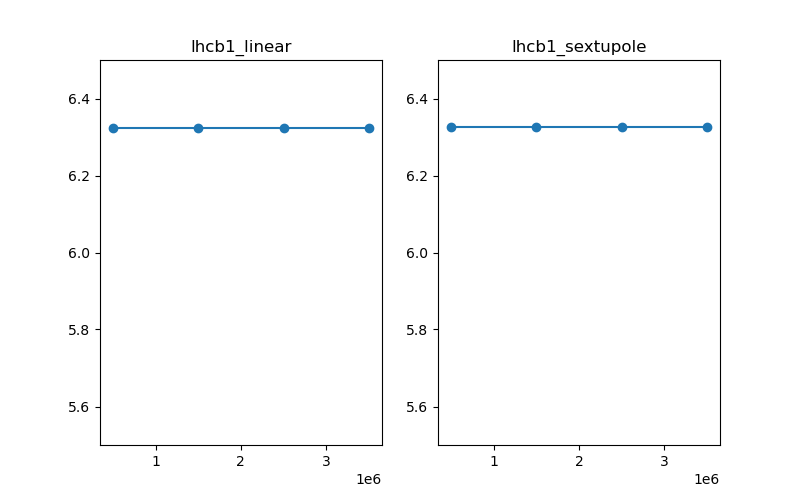

In [26]:
from scipy.signal import hilbert, chirp
%matplotlib widget

fig,axes = plt.subplots(1,2,figsize=(8,5))
for seq,ax in zip(sequenceNames,axes):
    _grouped = summary[(summary['sequence'].str.fullmatch(seq))].groupby('pt')
    plt.sca(ax)
    plt.title(seq)
    for gr in list(_grouped.groups.keys()):
        t = _grouped.get_group(gr)['turn']
        signal = _grouped.get_group(gr)[plane]/np.sqrt(twiss[f'bet{plane}'][0]*LHC_1sigma)
        
        bins = np.arange(t.iloc[0],t.iloc[-1],1000000)
        digitized = np.digitize(t,bins)
        bin_max = np.array([signal[digitized == i].max() for i in range(1, len(bins))])
        bin_times = bins[:-1] + np.diff(bins)/2
        
        plt.plot(bin_times,bin_max,'-o')
        #plt.plot(t[signal>6.2], signal[signal>6.2], label='envelope')
    #plt.ylabel(f'plane {plane}' + r'$x/\sqrt{\beta_x (2.5\cdot 10^{-6})/\gamma}$')
    #plt.xlabel(r'LHC turn')
    plt.ylim([5.5,6.5])
    
    

In [9]:
import itertools as itertools
from tqdm.notebook import tqdm
import Backend.BeamPhysics as BP

sequenceNames = ['lhcb1_linear','lhcb1_sextupole']

# Importing LHC sequence :
#===========================================
mad = Madx()
mad.option(echo = True, warn = True)
#for seq in sequenceNames:
#    mad.call(file=f'{seq}.seq')
    
dobrinCall = '''
Option, -echo,-warn,-info;
call,file="lhcb1_linear.seq";
call,file='/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx';

Option,  warn,info;
! my BEAM
 NRJ= 7000.0 ; ! collision
Nb:=2.2E11;
EMIT_BEAM:=2.5;
emittance_norm := EMIT_BEAM*1.0E-6;
gamma_rel      := NRJ/pmass;
epsx:=emittance_norm /gamma_rel;
epsy:=emittance_norm /gamma_rel;
value,gamma_rel,emittance_norm ;
Nb_0:=0;

  Beam,particle=proton,sequence=lhcb1_linear,energy=NRJ,sigt=0.130,bv=1,NPART=Nb_0,sige=4.5e-4,ex=epsx,ey=epsy;

  Use, sequence=lhcb1_linear;
 select,flag=twiss,clear;
  select, flag=twiss, pattern="IP1",   column=name,s,betx,bety,alfx,alfy,dx,dpx,mux,muy;
  select, flag=twiss, pattern="IP2",   column=name,s,betx,bety,alfx,alfy,dx,dpx,mux,muy;
  select, flag=twiss, pattern="IP5",   column=name,s,betx,bety,alfx,alfy,dx,dpx,mux,muy;
  select, flag=twiss, pattern="IP8",   column=name,s,betx,bety,alfx,alfy,dx,dpx,mux,muy;
SETPLOT,POST=1,FONT=4,ASCALE=1.,LSCALE=1.,SSCALE=1.,RSCALE=1.5;
PLOT,STYLE=100,colour=100,range=#s/#e,HAXIS=S,VAXIS1=BETX,BETY,VAXIS2=DX,
NOLINE=false,HMIN=0.,HMAX=3;
  twiss,sequence=lhcb1_linear,file=twiss.b1;system,"cat twiss.b1";'''

mad.input(dobrinCall)
mad.input(' select, flag=twiss,    column=name,k1L,,mux,muy;')

True

In [7]:
mad.table['twiss'].dframe()

name     keyword           s         betx  \
#s             lhcb1_linear$start:1      marker      0.0000  3354.545817   
ip1                           ip1:1      marker      0.0000  3354.545817   
drift_0[0]                drift_0:0       drift     22.9650  3354.702687   
mqxa.1r1                 mqxa.1r1:1  quadrupole     29.3350  3354.801904   
drift_1[0]                drift_1:0       drift     32.0500  3354.851545   
...                             ...         ...         ...          ...   
drift_2209[0]          drift_2209:0       drift  26629.5482  3354.802789   
mqxa.1l1                 mqxa.1l1:1  quadrupole  26635.9182  3354.703380   
drift_2210[0]          drift_2210:0       drift  26658.8832  3354.545817   
ip1.l1                     ip1.l1:1      marker  26658.8832  3354.545817   
#e               lhcb1_linear$end:1      marker  26658.8832  3354.545817   

                   alfx       mux          bety      alfy       muy    x  ...  \
#s             0.000008  0.000000  81426.487624 -0.011704  0.000000  0.0  ...   
ip1            0.000008  0.000000  81426.487624 -0.011704  0.000000  0.0  ...   
drift_0[0]    -0.006838  0.001090  81427.031649 -0.011986  0.000045  0.0  ...   
mqxa.1r1      -0.008737  0.001392  81427.184845 -0.012064  0.000057  0.0  ...   
drift_1[0]    -0.009547  0.001521  81427.250443 -0.012097  0.000063  0.0  ...   
...                 ...       ...           ...       ...       ...  ...  ...   
drift_2209[0]  0.008752  1.230277  81425.811541 -0.011343  0.052147  0.0  ...   
mqxa.1l1       0.006853  1.230579  81425.956554 -0.011422  0.052160  0.0  ...   
drift_2210[0]  0.000008  1.231669  81426.487624 -0.011704  0.052205  0.0  ...   
ip1.l1         0.000008  1.231669  81426.487624 -0.011704  0.052205  0.0  ...   
#e             0.000008  1.231669  81426.487624 -0.011704  0.052205  0.0  ...   

               sig54     sig55  sig56  sig61  sig62  sig63  sig64  sig65  \
#s               0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0   
ip1              0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0   
drift_0[0]       0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0   
mqxa.1r1         0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0   
drift_1[0]       0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0   
...              ...       ...    ...    ...    ...    ...    ...    ...   
drift_2209[0]    0.0  0.000001    0.0    0.0    0.0    0.0    0.0    0.0   
mqxa.1l1         0.0  0.000001    0.0    0.0    0.0    0.0    0.0    0.0   
drift_2210[0]    0.0  0.000001    0.0    0.0    0.0    0.0    0.0    0.0   
ip1.l1           0.0  0.000001    0.0    0.0    0.0    0.0    0.0    0.0   
#e               0.0  0.000001    0.0    0.0    0.0    0.0    0.0    0.0   

               sig66   n1  
#s               0.0  0.0  
ip1              0.0  0.0  
drift_0[0]       0.0  0.0  
mqxa.1r1         0.0  0.0  
drift_1[0]       0.0  0.0  
...              ...  ...  
drift_2209[0]    0.0  0.0  
mqxa.1l1         0.0  0.0  
drift_2210[0]    0.0  0.0  
ip1.l1           0.0  0.0  
#e               0.0  0.0  

[4426 rows x 256 columns]